## Tensor Unsupervised Anomaly Detection
This notebook is to use the organized data from `preprocess.ipynb` for tensor dimension reduction and anomaly detection. Currently, Jiuyun is working on this notebook.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the data
solar_tensor_data = pickle.load( open( "Data/solar_tensor.pickle", "rb" ) )

# inverter level monitoring data
inv_comp_reshaped = solar_tensor_data['inv_comp_reshaped'][:,0:17,:,:] # 20 inverters, 17 sensors, 731 days, 96 times

# inverter level 0/1 fault data
fault_code = solar_tensor_data['inv_comp_reshaped'][:,17,:,:] # 20 inverters, 731 days, 96 times, 0/1 variable

# module level monitoring data & fault code
module_data_reshaped = solar_tensor_data['module_data_reshaped'] # 20 inverters, 10 modules, fault code and 3 sensors, 731 days, 96 times

# module level temperature data
orgnized = solar_tensor_data['orgnized']



(20, 17, 731, 96)
(20, 10, 4, 70176)


In [2]:
# module level variable names
print(solar_tensor_data['var_names']) # fault + 3 sensors (module level)
# name of 17 inverter level monitoring variables
vars_inverter= ['Idc' ,'Pac', 'Pdc', 'Va', 'Vb', 'Vc', 'Vdc', 'pf','Ia' ,'Ib' ,'Ic' ,'t_inv_avg','t_inv_max','t_inv_min','t_igbt_avg','t_igbt_max','t_igbt_min','fault']
print(vars_inverter) # 17 sensors + fault (inverter level)

['fault', 'status', 'Tinv', 'Tigbt']
['Idc', 'Pac', 'Pdc', 'Va', 'Vb', 'Vc', 'Vdc', 'pf', 'Ia', 'Ib', 'Ic', 't_inv_avg', 't_inv_max', 't_inv_min', 't_igbt_avg', 't_igbt_max', 't_igbt_min', 'fault']


### Temperature analysis

In [3]:
Tigbt=orgnized[:,:,3,::-1].reshape(20,10,731,96) # inv, mod, day, time
Tinv=orgnized[:,:,2,::-1].reshape(20,10,731,96)

In [4]:
import tensorly as tl
from tensorly.decomposition import tucker
core, factors = tucker(Tigbt,rank=[5,3,25,10])
Tigbt_recons = tl.tenalg.multi_mode_dot(core,factors)

Text(0.5, 1.0, 'Reconstruction examples of modules in inverter A')

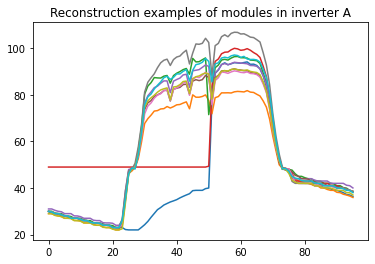

In [6]:
for i in range(10):
    plt.plot(Tigbt[0,i,346,:])
plt.title('Reconstruction examples of modules in inverter A')
#plt.plot(Tigbt_recons[0,0,395,:])

Text(0.5, 1.0, 'Reconstruction of IGBT temperature in inverter A module 6')

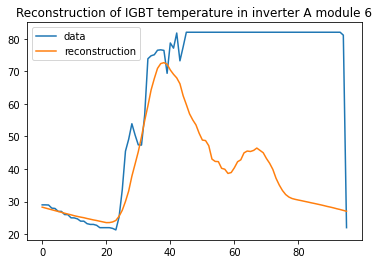

In [8]:
plt.plot(Tigbt[0,5,337,:], label = 'data')
plt.plot(Tigbt_recons[0,5,337,:], label = 'reconstruction')
plt.legend()
plt.title('Reconstruction of IGBT temperature in inverter A module 6')

### Fault code organize



In [9]:
multi_fault_code=orgnized[:,:,0,:].reshape(20,10,731,96) # 20 inverters, 10 modules, 731 days, 96 times, specific fault codes
np.unique(multi_fault_code) # what are the possible fault codes

array([ 0.,  1.,  4.,  5., 12., 13., 14., 15., 16., 18., 19., 20., 21.,
       26., 36., 40., 41., 42., 48., 50., 53., 55., 61., 62., 65., 67.,
       83., 84., 85., 86., 95.])

In [10]:
# daywise T/F variable for different fault code
fault_list=np.unique(multi_fault_code)
fault_list=np.delete(fault_list,0)
multi_fault=np.zeros([30,20,731])
for i in range(30):
    multi_fault[i,:,:]=np.sum(np.sum(multi_fault_code==fault_list[i],axis=1),axis=2)!=0 # 30 fault codes, 20 inverters, 731 days

In [11]:
# T/F variable for overall fault everyday
fault_code_day=np.sum(fault_code,axis=2)!=0 # 20 inverters, 731 days, 0/1 binary
fault_code_day.shape

(20, 731)

### 4/21/2023 Inverter level residual v.s. day fault

In [12]:
# center by median
data_median = np.median(inv_comp_reshaped,axis=0)
data = inv_comp_reshaped - data_median

In [13]:
# perform Tucker decomposition
from tensorly.decomposition import partial_tucker, parafac
import tensorly as tl
core, factors = partial_tucker(data, modes = [2,3], rank=[100,15])

In [14]:
# reconstruction error
data_recons = tl.tenalg.multi_mode_dot(core, factors, modes = [2,3])
data_residual = np.sum((data-data_recons)**2, axis=3) # 20 inverters, 17 sensor, 731 days, reconstruction error
max_temp = np.max(data_residual, axis=2)
data_residual_regular = np.transpose(1-np.transpose(data_residual,(2,0,1))/max_temp, (1,2,0)) # 20 inverters, 17 sensors, 731 days, regularized residual
np.max(data_residual_regular)

0.9999999999397

In [16]:
# 20 inverters, 731 days, proportion of module fault
data_fault = np.mean(np.sum(multi_fault_code,axis=3)>0,axis=1)

In [19]:
# Aggregate 17 sensors
data_1=np.mean(data_residual_regular[:,:3,:],axis=1)
data_2=np.mean(data_residual_regular[:,3:7,:],axis=1)
data_3=np.mean(data_residual_regular[:,7:8,:],axis=1)
data_4=np.mean(data_residual_regular[:,8:11,:],axis=1)
data_5=np.mean(data_residual_regular[:,11:14:],axis=1)
data_6=np.mean(data_residual_regular[:,14:17,:],axis=1)
data_aggregate=np.stack((data_1,data_2,data_3,data_4,data_5,data_6),axis=1) # 20 inverters, 6 sensors, 731 days, aggregated accuracy data
data_sort = np.sort(data_aggregate, axis = 1) # sensor variable sorted data for 20 inverters and 731 days

Text(0.5, 1.0, 'Residual analysis for all data')

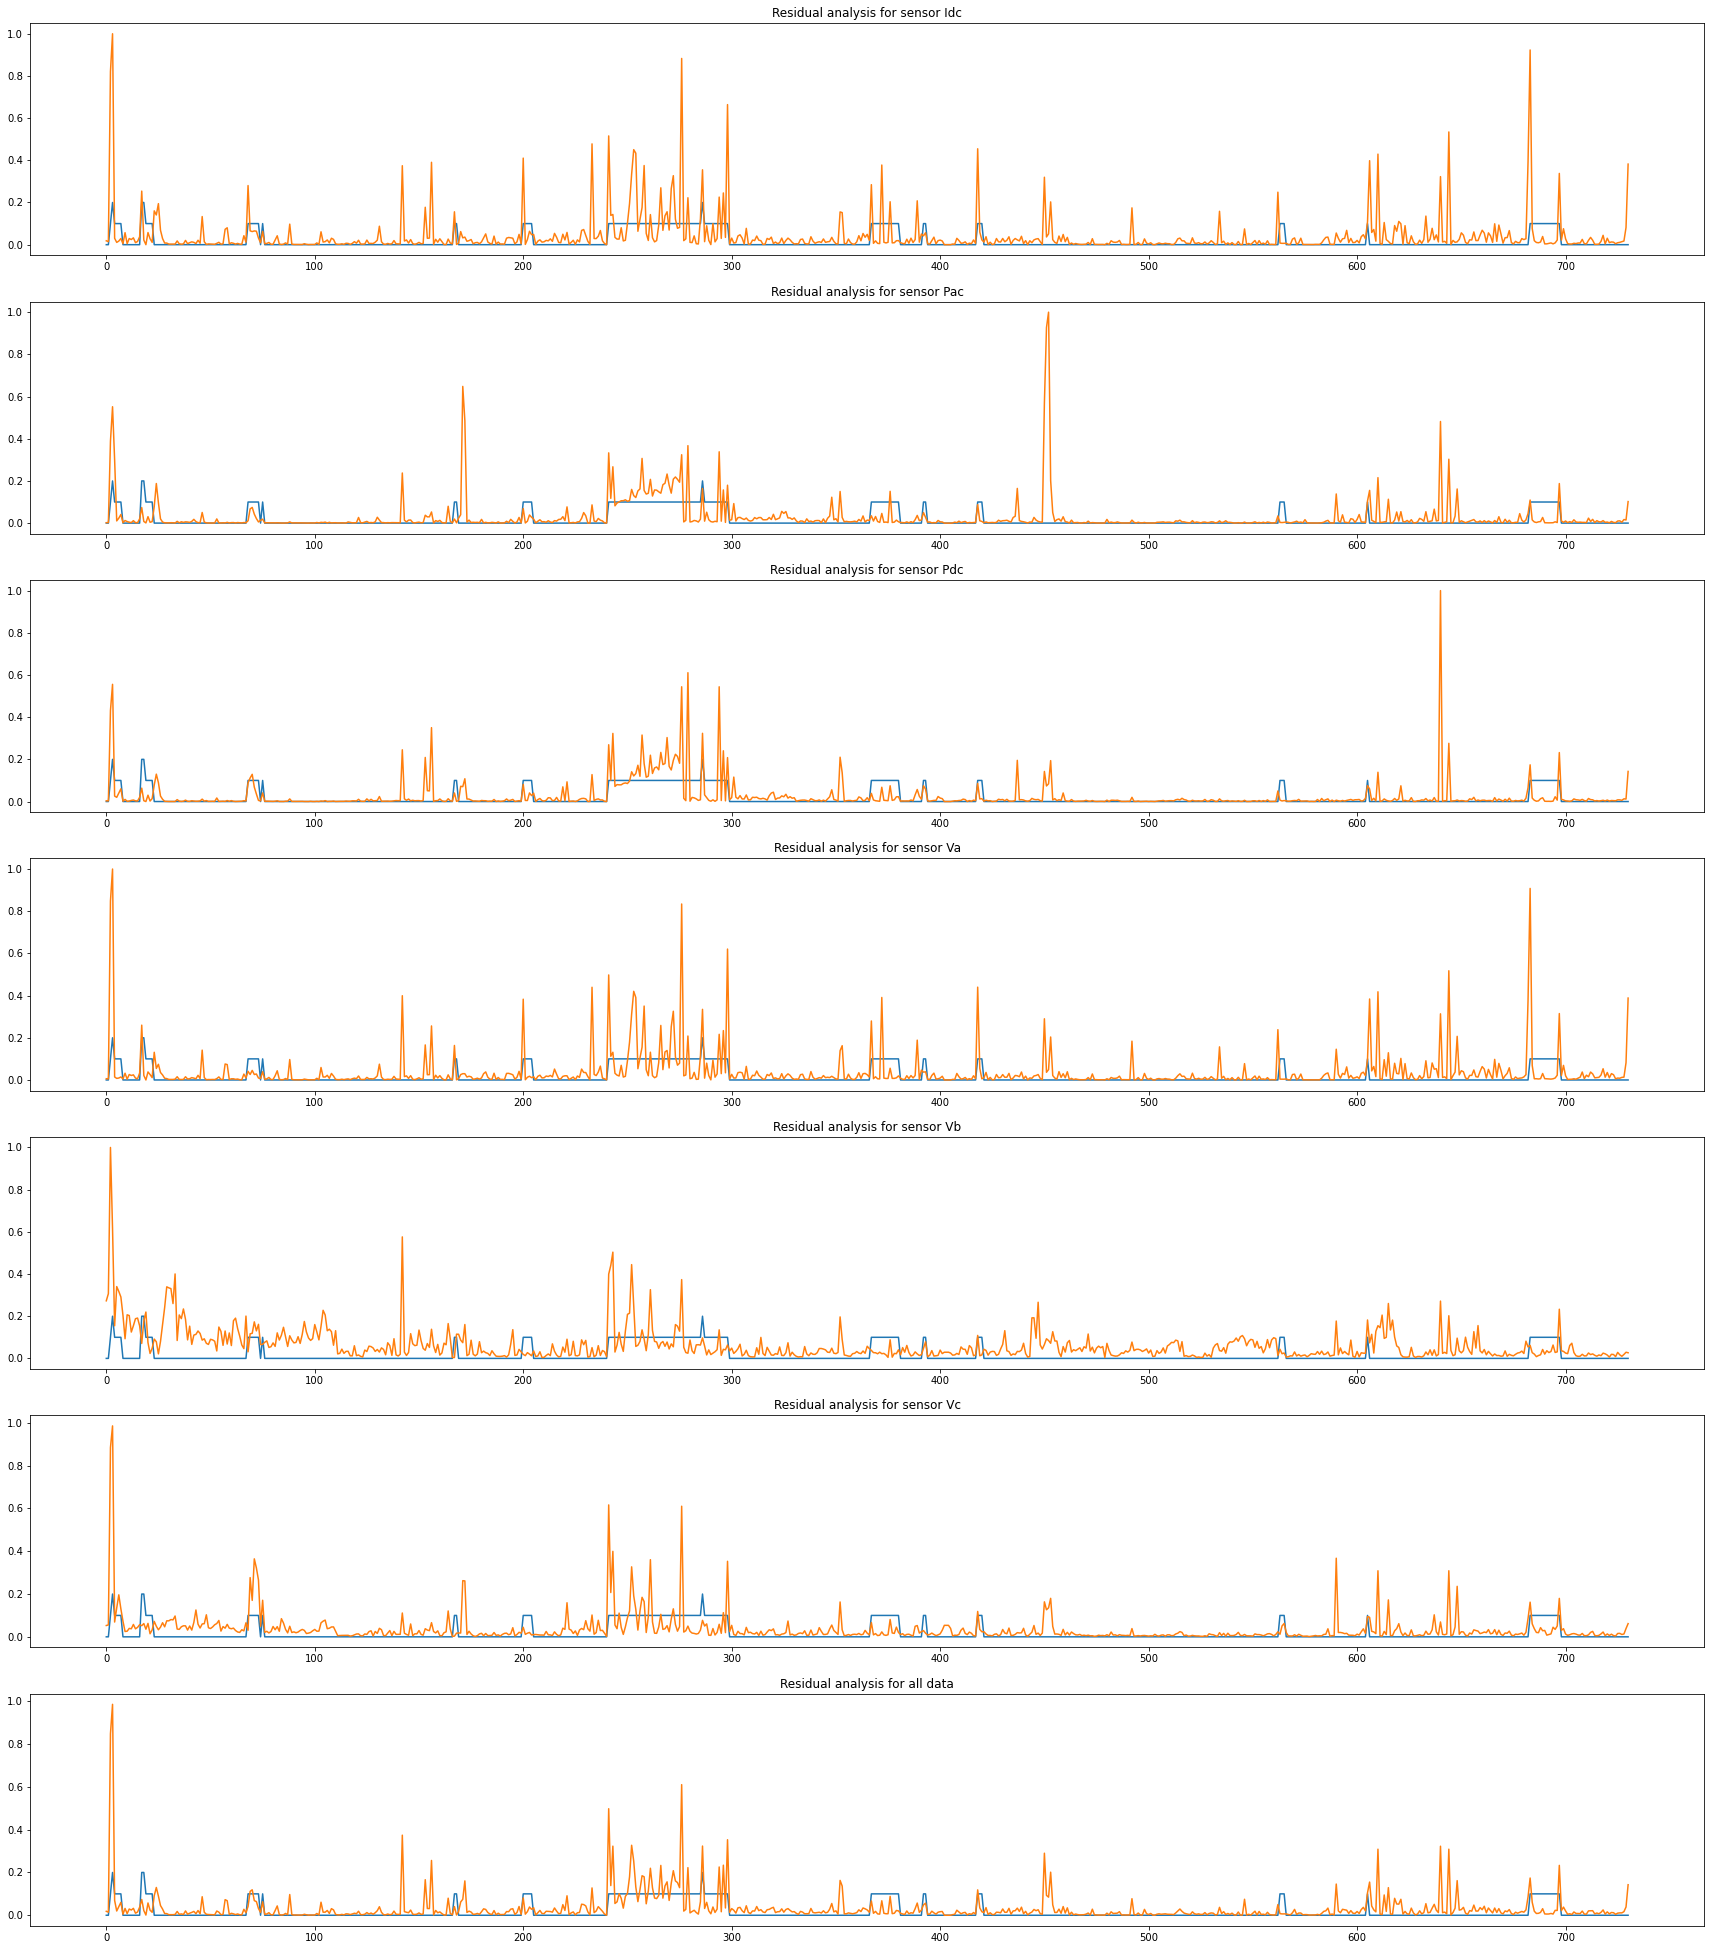

In [21]:
fig, axs = plt.subplots(7, 1, figsize=(30, 7*5))
for i in range(6):
    axs[i].plot(data_fault[5], label = 'True proportion of module failure')
    axs[i].plot(1-data_aggregate[5,i], label = 'Reconstruction residual')
    axs[i].set_title('Residual analysis for sensor '+ vars_inverter[i])
axs[6].plot(data_fault[5])
axs[6].plot(1-data_sort[5,2])
axs[6].set_title('Residual analysis for all data')

In [22]:
thres = np.quantile(1-data_sort[:,1,:],0.90) # 90% quantile threshold
alert_days=14 # 2 weeks window
TP=np.zeros(731-alert_days) # from day 7 to day 731
FN=np.zeros(731-alert_days) # from day 7 to day 731
FP=np.zeros(731-alert_days) # from day 1 to day 724

for i in range(len(TP)):
    temp = np.sum((1-data_sort[:,1,i:i+alert_days])>thres, axis=1)>0
    TP[i]= np.sum(temp*data_fault_inverter[:,i+alert_days])/(np.sum(data_fault_inverter[:,i+alert_days])+0.0001)
    FN[i]=(1-TP[i])*(np.sum(data_fault_inverter[:,i+alert_days])>0)
    temp = np.sum(data_fault_inverter[:,i:i+alert_days], axis=1)>0
    FP[i] = np.sum(((1-data_sort[:,1,i])>thres) * (1-temp)) /(np.sum(1-temp)+0.0001)

In [30]:
already_fault = np.array(fault_res).reshape(-1)
time_delay = np.array(res).reshape(-1)
# time_delay_not0 = time_delay[time_delay!=0]


In [36]:
for inv in range(2):
    fig, axs = plt.subplots(2, 1, figsize=(30, 2*5), dpi=800)
    axs[0].plot(data_fault[inv], label = 'Module proportion fault')
    axs[0].plot((1-data_sort[inv,1])*((1-data_sort[inv,1])>thres), label = 'Relative error')
    axs[0].set_title('Residual analysis for '+solar_tensor_data['inverters_name'][inv])
    # axs[0].plot([0,731], [thres,thres], color='r', linestyle='-', label = 'Threshold')
    axs[0].legend()

    axs[1].fill_between(np.arange(731-alert_days),TP, label = 'TPR')
    axs[1].fill_between(np.arange(731-alert_days),1-FN,1, label = 'FNR')
    axs[1].set_title('True positive rate and false negative rate')
    axs[1].legend()

#    fig.savefig('Fault_Prediction_{}_Result.png'.format(inv), dpi=800)

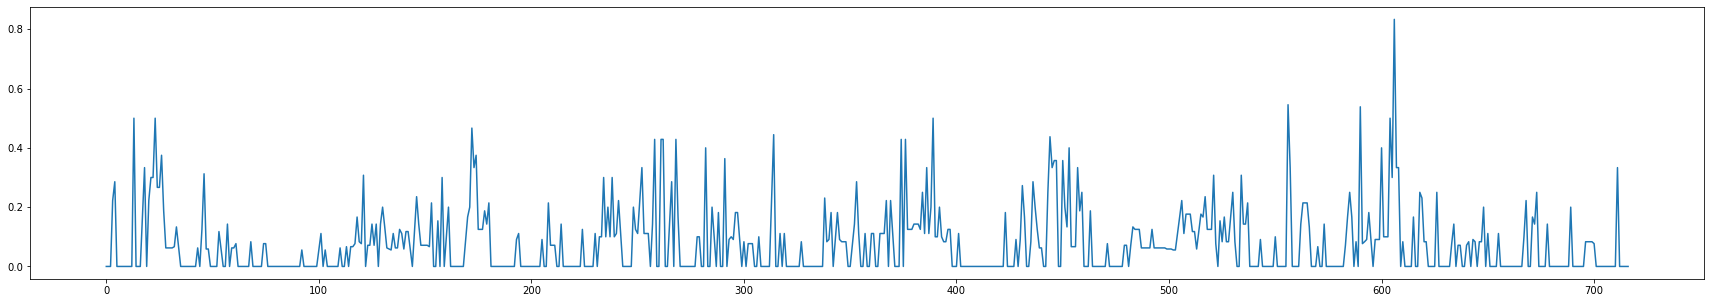

In [37]:
plt.figure(figsize=(30,5))
plt.plot(FP)

In [38]:
F1=2*TP/(2*TP+FP+FN+0.001)
np.nanmean(F1)

0.7799072835889455

In [292]:
import pickle

inverter_residual_data = {"data_residual":data_residual, "data_residual_normalized":data_residual_regular}

pickle.dump(inverter_residual_data, open("Data/inverter_residual_data.pickle","wb"))

## Inverter not included
The four dimensions of inv_comp_reshaped are inverters, variables, days, time. We apply Tucker decomposition on time and variables. The core tensor will have four dimensions where variables and time will be pricipal components

In [39]:
import tensorly as tl
import numpy as np
import matplotlib.pyplot as plt
tl.set_backend('numpy')

# get the rank of the dimensions
M0=tl.unfold(inv_comp_reshaped, mode=0)
print(np.linalg.matrix_rank(M0))

M1=tl.unfold(inv_comp_reshaped, mode=1)
print(np.linalg.matrix_rank(M1))

M2=tl.unfold(inv_comp_reshaped, mode=2)
print(np.linalg.matrix_rank(M2))

M3=tl.unfold(inv_comp_reshaped, mode=3)
print(np.linalg.matrix_rank(M3))

20


15


729


96


In [40]:
np.mean(inv_comp_reshaped,axis=0).shape

(17, 731, 96)

#### 1. Normalization
In each day and each time, each variable is deducted the mean for all 20 inverters.

In [41]:
# Delete the day trend of each day
inv_comp_reshaped_1=inv_comp_reshaped.copy()
for i in range(96):
    for j in range(17):
        for k in range(731):
            inv_comp_reshaped_1[:,j,k,i]=(inv_comp_reshaped_1[:,j,k,i]-np.mean(inv_comp_reshaped_1[:,j,k,i]))

#for i in range(20):
#    for j in range(17):
#        for k in range(96):
#            inv_comp_reshaped_1[i,j,k,:]-=np.mean(inv_comp_reshaped_1[i,j,k,:])

In [42]:

from tensorly.decomposition import partial_tucker, parafac

core, factors = partial_tucker(inv_comp_reshaped_1, modes = [1,3], rank=[10,48])

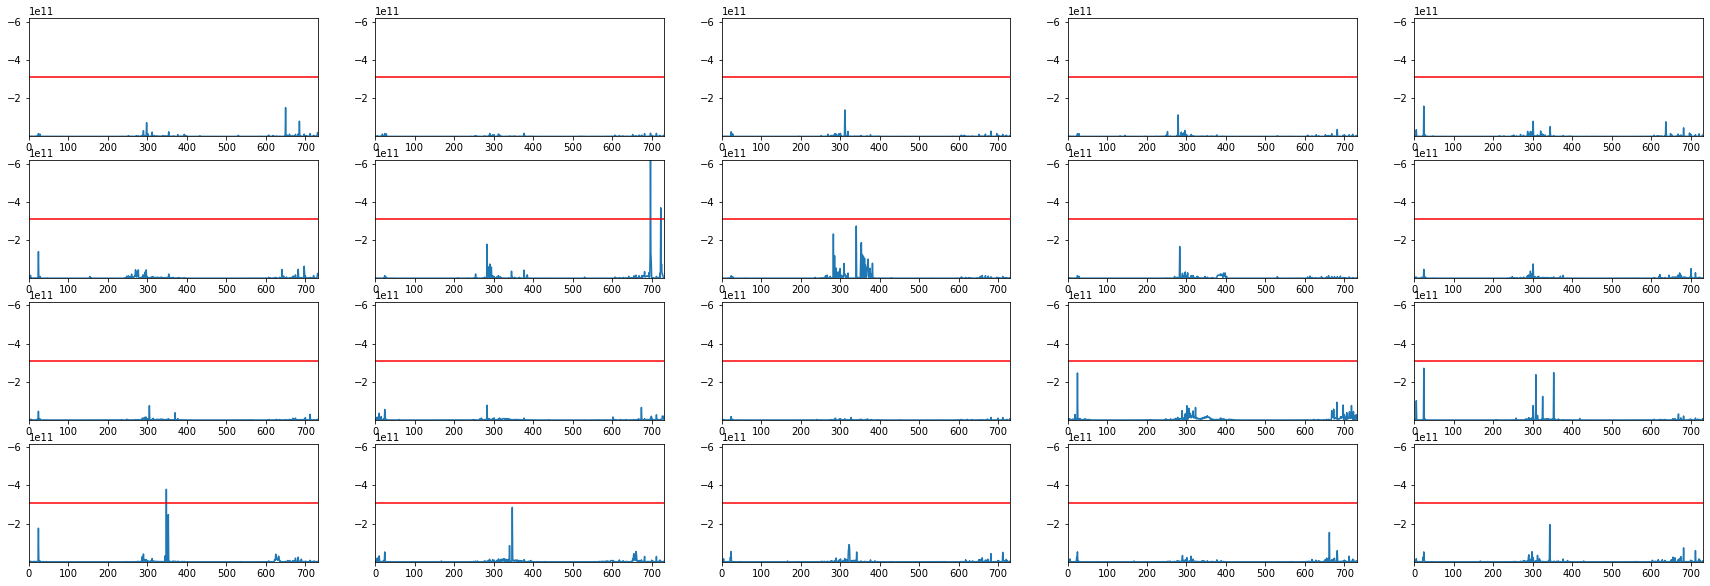

In [43]:
temp=np.sum(np.sum(core**2,3),1)-np.sum(np.sum(inv_comp_reshaped_1**2,3),1)
x=range(1,732)
plt.subplots(figsize=[30,10])
for i in range(1,21):
    fig=plt.subplot(4,5,i)
    plt.plot(x,temp[i-1])
    plt.axhline(y=0.5*np.min(temp), color='r', linestyle='-')
    plt.axis([0,731,np.max(temp),np.min(temp)])
plt.show()

### Plot tensor level statistics
For each of the tensor, plot the L2 norm of the tensor of principal component of variables and time. The x-axis is day.

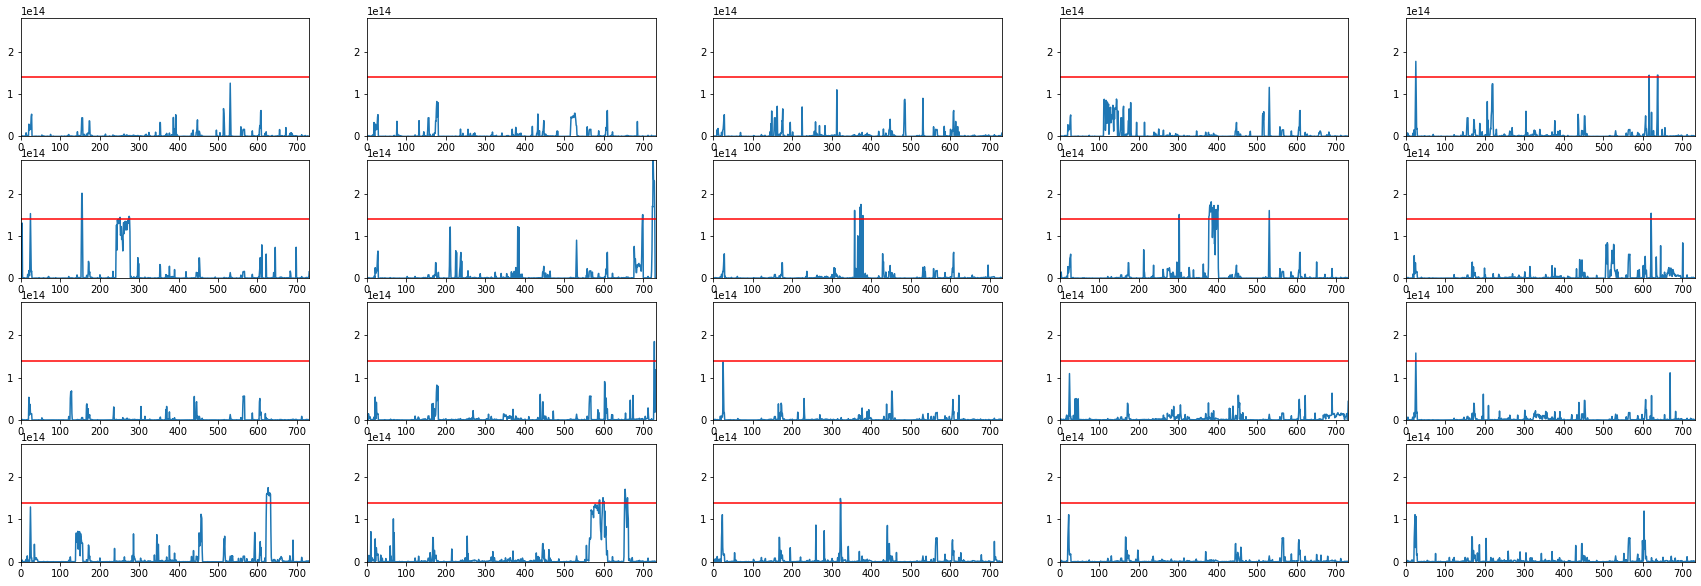

In [44]:
statistics=np.sum(np.sum(core**2,3),1)
x=range(1,732)
plt.subplots(figsize=[30,10])
for i in range(1,21):
    fig=plt.subplot(4,5,i)
    plt.plot(x,statistics[i-1])
    plt.axhline(y=0.5*np.max(statistics), color='r', linestyle='-')
    plt.axis([0,731,0,np.max(statistics)])
plt.show()

In [45]:
# overall AUC
from sklearn.metrics import roc_curve,roc_auc_score
roc_auc_score(fault_code_day.reshape(-1,),statistics.reshape(-1,))

0.6161459487720273

### Get the decomposition residual
Reconstruct the tensor and get the residual of each inverter and each day.

In [46]:
data_rec = tl.tenalg.multi_mode_dot(core,factors,modes=[1,3])
data_resid = inv_comp_reshaped_1 - data_rec
data_resid.shape

(20, 17, 731, 96)

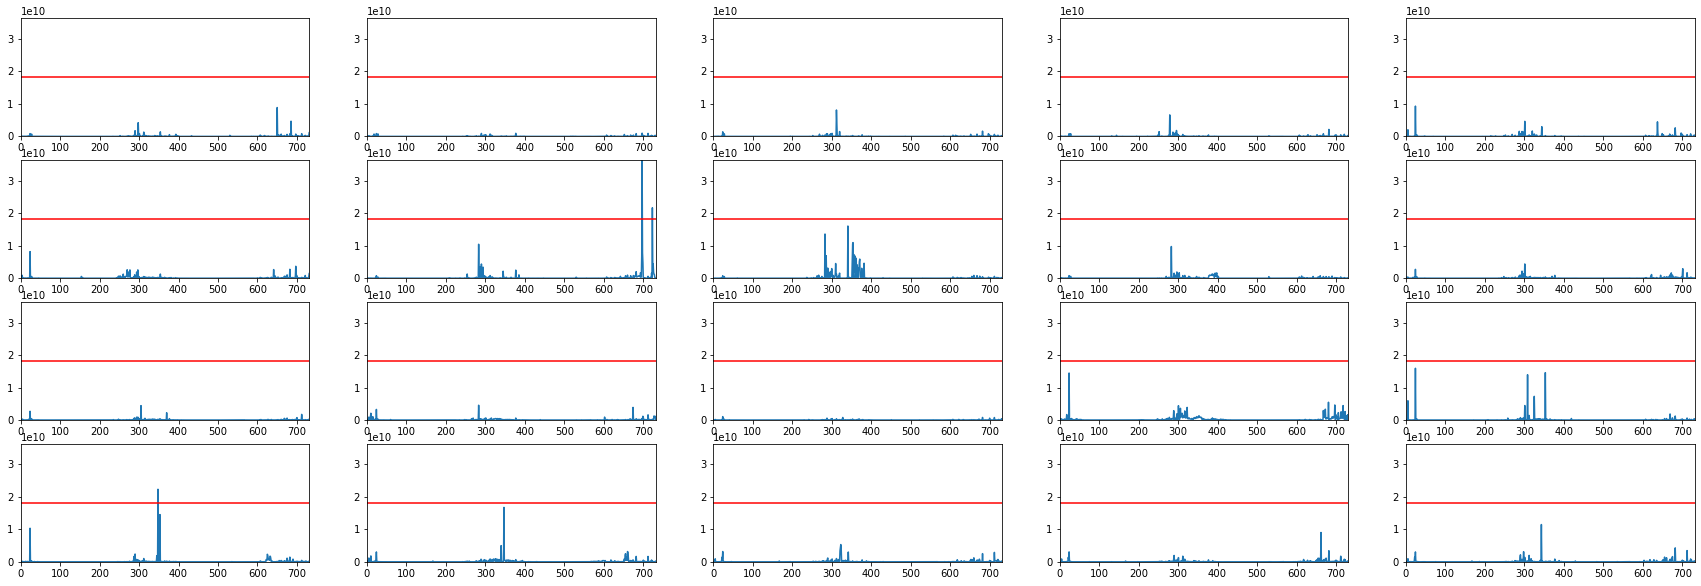

In [47]:
resid_stat=np.mean(np.sum(data_resid**2,3),1)
x=range(1,732)
plt.subplots(figsize=[30,10])
for i in range(1,21):
    fig=plt.subplot(4,5,i)
    plt.plot(x,resid_stat[i-1])
    plt.axhline(y=0.5*np.max(resid_stat), color='r', linestyle='-')
    plt.axis([0,731,0,np.max(resid_stat)])
plt.show()
#print(np.where(resid_stat>0.3*np.max(resid_stat)))

In [48]:
roc_auc_score(fault_code_day.reshape(-1,),resid_stat.reshape(-1,))

0.6327109673490994

In [49]:
# auc for different fault code
for i in range(30):
    temp=roc_auc_score(multi_fault[i,:,:].reshape(-1,),resid_stat.reshape(-1,))
    print('AUC for failure code '+str(fault_list[i]),temp)

AUC for failure code 1.0 0.42942558299039785
AUC for failure code 4.0 0.6576414977267855
AUC for failure code 5.0 0.5510624828907748
AUC for failure code 12.0 0.8873915915757208
AUC for failure code 13.0 0.9908338463643204
AUC for failure code 14.0 0.6537123135694024
AUC for failure code 15.0 0.7473758671047828
AUC for failure code 16.0 0.7422345374931582
AUC for failure code 18.0 0.6543691784472475
AUC for failure code 19.0 0.4561477684115953
AUC for failure code 20.0 0.5966958544260501
AUC for failure code 21.0 0.6055509924709104
AUC for failure code 26.0 0.4609995209416918
AUC for failure code 36.0 0.5058817174055992
AUC for failure code 40.0 0.603041876762255
AUC for failure code 41.0 0.5163675115727768
AUC for failure code 42.0 0.7114532151249733
AUC for failure code 48.0 0.6246150424308787
AUC for failure code 50.0 0.5247296372347707
AUC for failure code 53.0 0.6806683410508735
AUC for failure code 55.0 0.6229694526262504
AUC for failure code 61.0 0.43870620038324665
AUC for fail

### Exploration for failure code 12-16

In [50]:
fault_Desat=np.sum(multi_fault[range(3,8),:,:],axis=0)!=0
roc_auc_score(fault_Desat.reshape(-1,),resid_stat.reshape(-1,))

0.7927387275528271

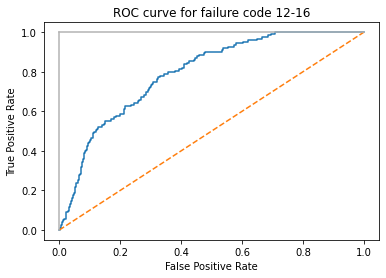

In [53]:
fpr1, tpr1, thres1=roc_curve( fault_Desat.reshape(-1,),resid_stat.reshape(-1,))

plt.title('ROC curve for failure code 12-16')
plt.plot(fpr1, tpr1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

185581921.5871148


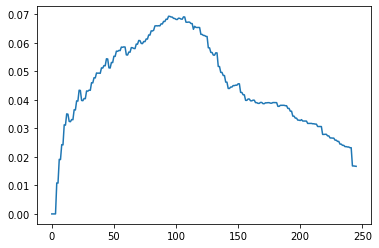

In [54]:
from sklearn.metrics import f1_score
# get threshold to maximize F1 score
f1_1=[]
for i in thres1:
    y_pred = np.where(resid_stat.reshape(-1,) > i, 1, 0)
    f1_1.append( f1_score(fault_Desat.reshape(-1,), y_pred))

plt.plot(f1_1)
thres1_opt=thres1[np.argmax(f1_1)]
print(thres1_opt)

### Exploration for failure code 83\-86



In [55]:
fault_Temp=np.sum(multi_fault[range(26,30),:,:],axis=0)!=0
roc_auc_score(fault_Temp.reshape(-1,),resid_stat.reshape(-1,))

0.7175233044916637

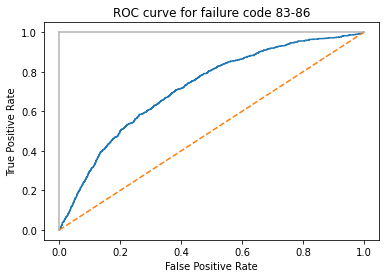

In [56]:
fpr2, tpr2, thres2=roc_curve( fault_Temp.reshape(-1,),resid_stat.reshape(-1,))

plt.title('ROC curve for failure code 83-86')
plt.plot(fpr2, tpr2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

82188727.94537948


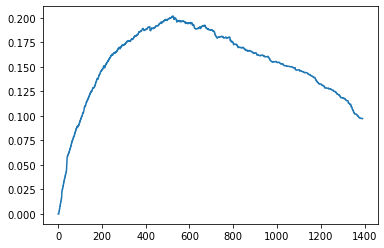

In [57]:
# get threshold to maximize F1 score
f1_2=[]
for i in thres2:
    y_pred = np.where(resid_stat.reshape(-1,) > i, 1, 0)
    f1_2.append( f1_score(fault_Temp.reshape(-1,), y_pred))

plt.plot(f1_2)
thres2_opt=thres2[np.argmax(f1_2)]
print(thres2_opt)

### Explore the principal components



<Figure size 432x288 with 0 Axes>

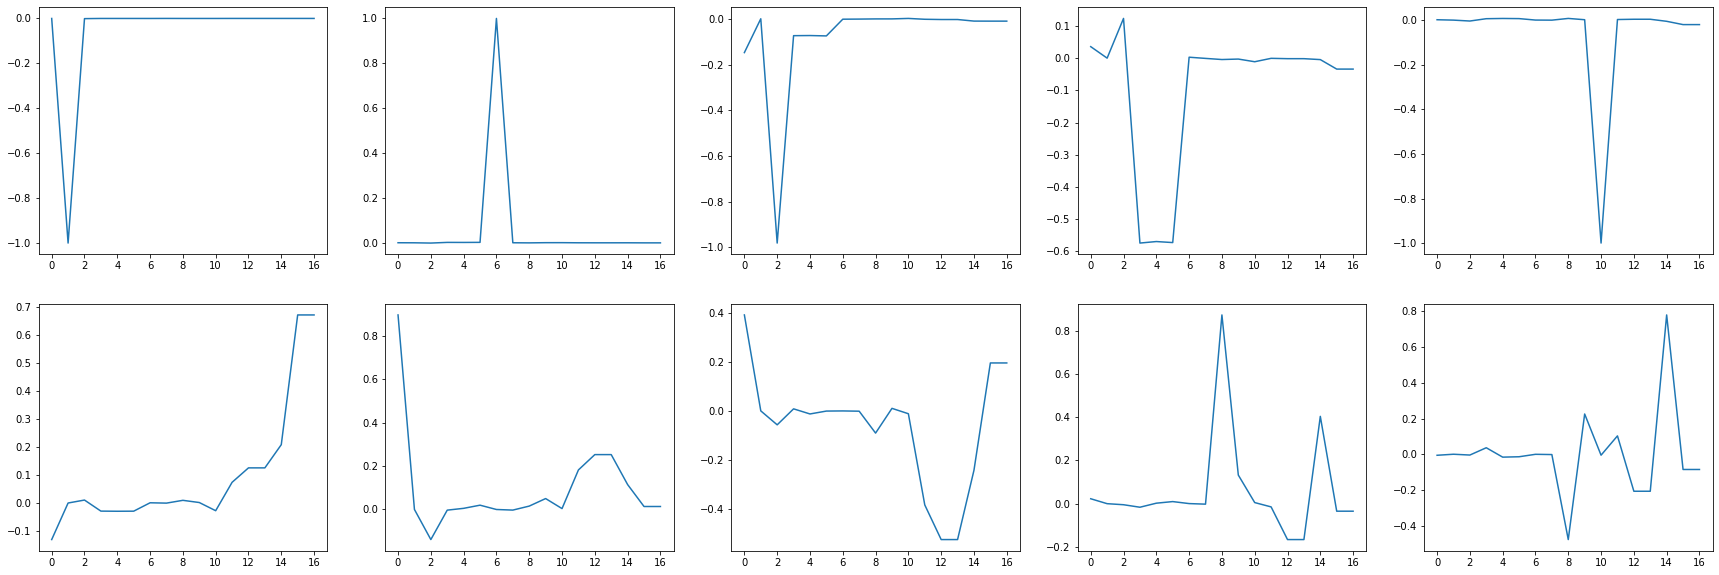

In [58]:
plt.figure()
plt.subplots(figsize=[30,10])
for i in range(1,11):
    fig=plt.subplot(2,5,i)
    plt.plot(factors[0][:,i-1])
plt.show()

## Train Test Generalization

In [59]:
inv_comp_reshaped_train=inv_comp_reshaped_1[:,:,0:500,:]
inv_comp_reshaped_test=inv_comp_reshaped_1[:,:,500:,:]

In [60]:
core_train, factors_train = partial_tucker(inv_comp_reshaped_train, modes = [1,3], rank=[10,48])
factors_T=[factors_train[0].T,factors_train[1].T]
core_test=tl.tenalg.multi_mode_dot(inv_comp_reshaped_test,factors_T,modes=[1,3])

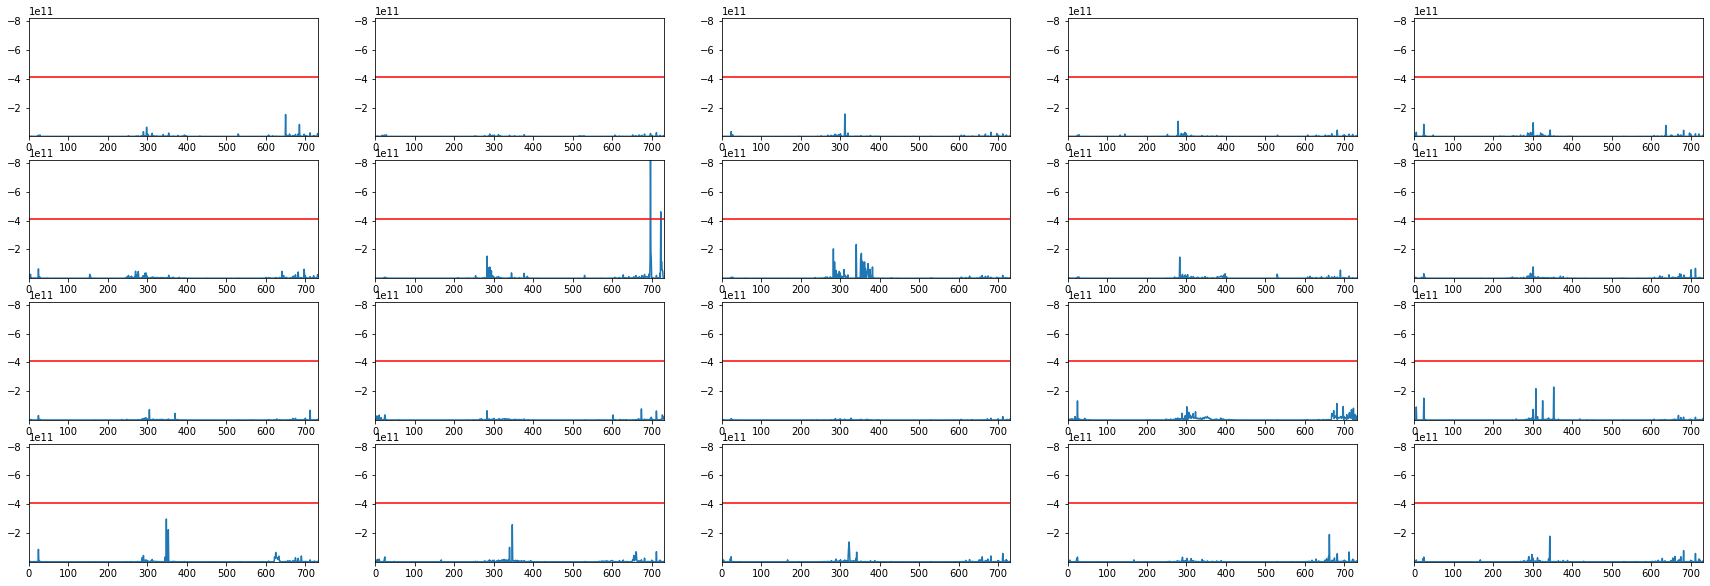

In [61]:
core_comb=np.concatenate((core_train,core_test),axis=2)
temp=np.sum(np.sum(core_comb**2,3),1)-np.sum(np.sum(inv_comp_reshaped_1**2,3),1)
x=range(1,732)
plt.subplots(figsize=[30,10])
for i in range(1,21):
    fig=plt.subplot(4,5,i)
    plt.plot(x,temp[i-1])
    plt.axhline(y=0.5*np.min(temp), color='r', linestyle='-')
    plt.axis([0,731,np.max(temp),np.min(temp)])
plt.show()

In [62]:
auc_train=roc_auc_score(fault_code_day[:,0:500].reshape(-1,),temp[:,0:500].reshape(-1,)*-1)
auc_test=roc_auc_score(fault_code_day[:,500:].reshape(-1,),temp[:,500:].reshape(-1,)*-1)
print('Overall AUC on the train set is '+ str(auc_train))
print('Overall AUC on the test set is '+ str(auc_test))

Overall AUC on the train set is 0.6477359078590785
Overall AUC on the test set is 0.6119466091509941


In [63]:
auc_Desat_train=roc_auc_score(fault_Desat[:,0:500].reshape(-1,),temp[:,0:500].reshape(-1,)*-1)
auc_Desat_test=roc_auc_score(fault_Desat[:,500:].reshape(-1,),temp[:,500:].reshape(-1,)*-1)
print('Desat based AUC on the train set is '+ str(auc_Desat_train))
print('Desat based AUC on the test set is '+ str(auc_Desat_test))

Desat based AUC on the train set is 0.8131682994015337
Desat based AUC on the test set is 0.7447465337954939


In [64]:
auc_Temp_train=roc_auc_score(fault_Temp[:,0:500].reshape(-1,),temp[:,0:500].reshape(-1,)*-1)
auc_Temp_test=roc_auc_score(fault_Temp[:,500:].reshape(-1,),temp[:,500:].reshape(-1,)*-1)
print('Temp based AUC on the train set is '+ str(auc_Temp_train))
print('Temp based AUC on the test set is '+ str(auc_Temp_test))

Temp based AUC on the train set is 0.7158010667625634
Temp based AUC on the test set is 0.6960508580884512


## Include inverter
When inverter is included, the study of core tensor will be dropped because the physical meaning does not make sense. We will study the reconstruction error only.

In [65]:
from tensorly.decomposition import partial_tucker, parafac

core, factors = partial_tucker(inv_comp_reshaped_1, modes = [0,1,3], rank=[15,10,48])

print(core.shape, factors[0].shape, factors[1].shape, factors[2].shape)

(15, 10, 731, 48) (20, 15) (17, 10) (96, 48)


In [72]:
factors[0].shape

(20, 15)

In [66]:
data_rec_1 = tl.tenalg.multi_mode_dot(core,factors,modes=[0,1,3])
data_resid_1 = inv_comp_reshaped_1 - data_rec_1
data_resid_1.shape

(20, 17, 731, 96)

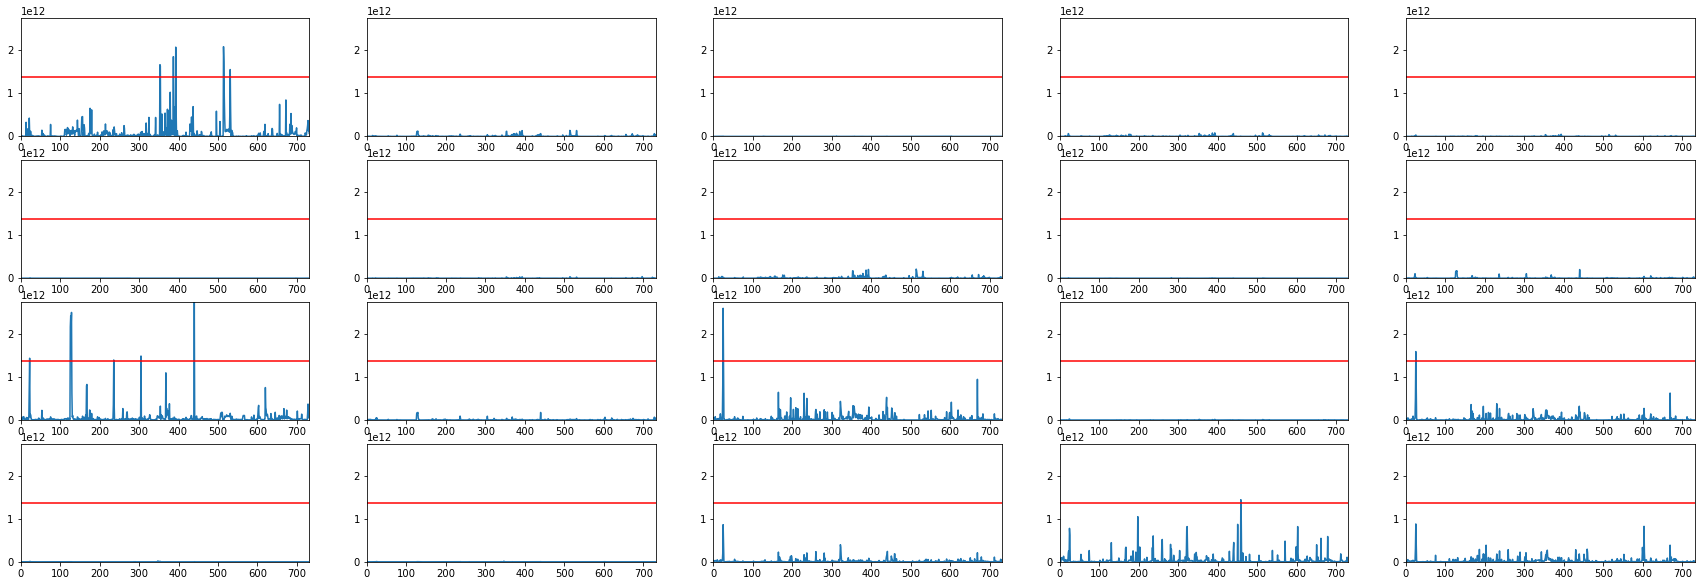

In [67]:
resid_stat_1=np.mean(np.sum(data_resid_1**2,3),1)
x=range(1,732)
plt.subplots(figsize=[30,10])
for i in range(1,21):
    fig=plt.subplot(4,5,i)
    plt.plot(x,resid_stat_1[i-1])
    plt.axhline(y=0.5*np.max(resid_stat_1), color='r', linestyle='-')
    plt.axis([0,731,0,np.max(resid_stat_1)])
plt.show()

In [68]:
roc_auc_score(fault_code_day.reshape(-1,),resid_stat_1.reshape(-1,))

0.5443455681533069

In [69]:
for i in range(30):
    temp=roc_auc_score(multi_fault[i,:,:].reshape(-1,),resid_stat_1.reshape(-1,))
    print('AUC for failure code '+str(fault_list[i]),temp)

AUC for failure code 1.0 0.3184653635116598
AUC for failure code 4.0 0.5653376079815312
AUC for failure code 5.0 0.3286511086777991
AUC for failure code 12.0 0.5684623312105277
AUC for failure code 13.0 0.6850673780696355
AUC for failure code 14.0 0.2278656555952054
AUC for failure code 15.0 0.20783132530120482
AUC for failure code 16.0 0.9058052818828681
AUC for failure code 18.0 0.4813464971278224
AUC for failure code 19.0 0.44382950611737965
AUC for failure code 20.0 0.6634970584211247
AUC for failure code 21.0 0.5545106091718002
AUC for failure code 26.0 0.4157285108130304
AUC for failure code 36.0 0.2732786546281618
AUC for failure code 40.0 0.5097298679851081
AUC for failure code 41.0 0.5909418659314517
AUC for failure code 42.0 0.6470305490279854
AUC for failure code 48.0 0.6964994525047906
AUC for failure code 50.0 0.2856810403832991
AUC for failure code 53.0 0.6967515699948688
AUC for failure code 55.0 0.6335203215901362
AUC for failure code 61.0 0.6781754722146182
AUC for fai

### Study the principal components of inverters

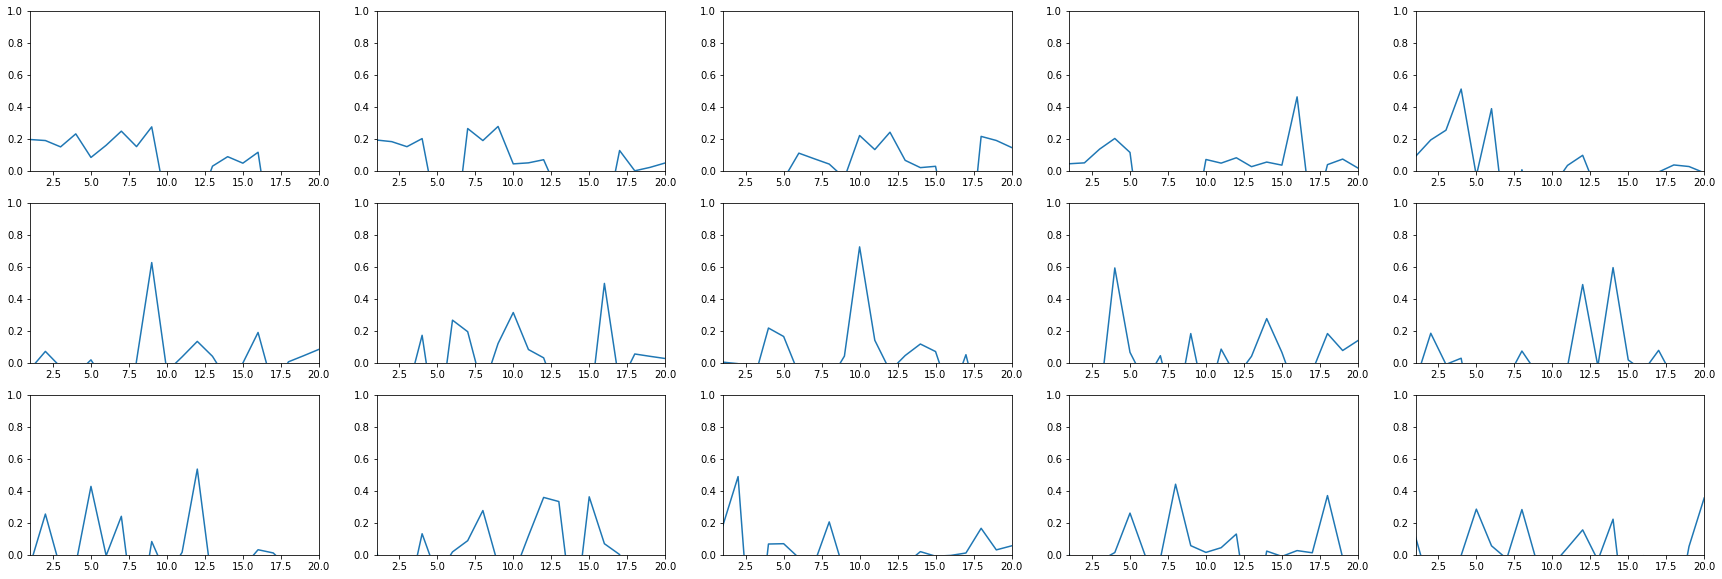

In [73]:
#plt.figure()
plt.subplots(figsize=[30,10])
for i in range(1,16):
    fig=plt.subplot(3,5,i)
    plt.plot(range(1,21),factors[0][:,i-1])
    plt.axis([1,20,0,1])
plt.show()

### Study the principal components of variables

The principal components of variables are the similar to the principal components without inve  
rters.



<Figure size 432x288 with 0 Axes>

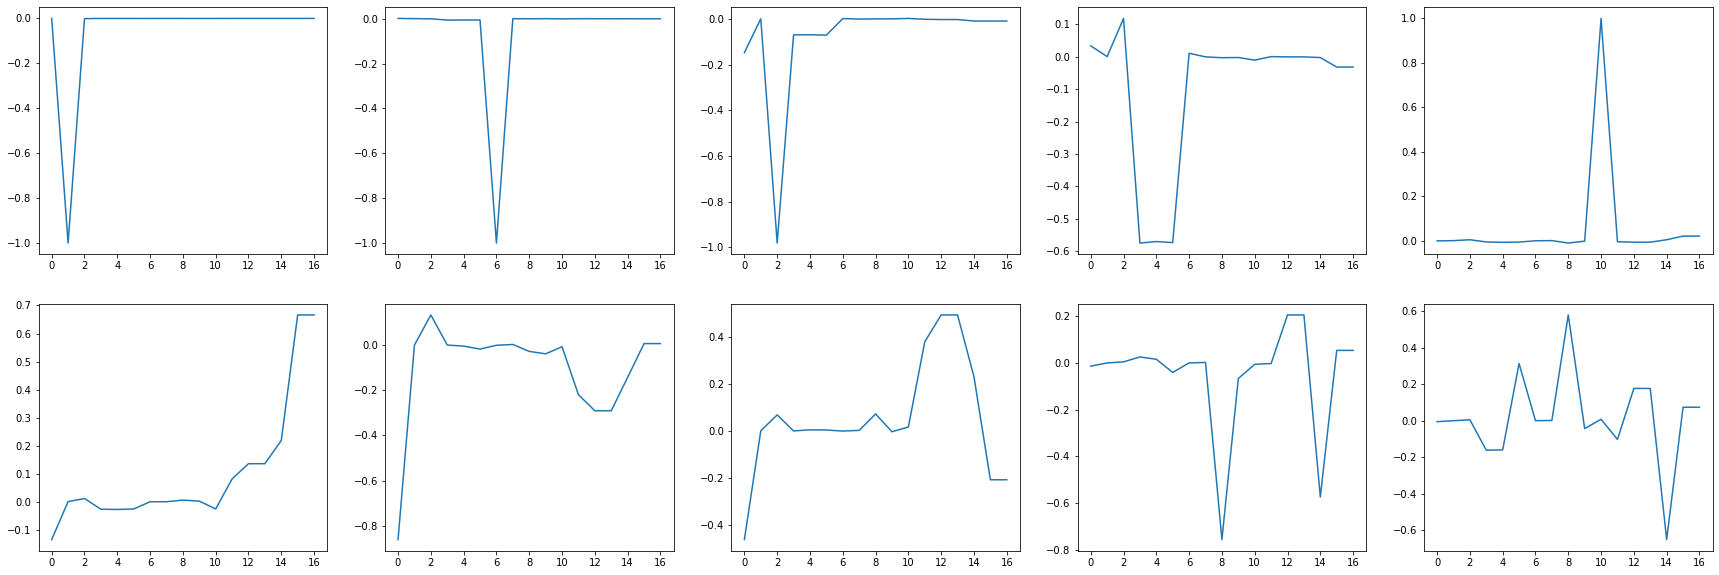

In [71]:
plt.figure()
plt.subplots(figsize=[30,10])
for i in range(1,11):
    fig=plt.subplot(2,5,i)
    plt.plot(factors[1][:,i-1])
plt.show()